<div align = "center">

# **Frecuencia-Severidad**

</div>

## Librerias

In [41]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

## Data

In [42]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [43]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Grupo_Edad,valor,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41-63,64667906,2,1834,2558114,10,1279057
2,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,76728037,2,1203,4883644,7,2441822
3,1997,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41-63,121930553,2,3077,4238816,16,2119408
4,1998,AZUL,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,130833256,2,2791,8213167,16,4106584
5,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,101517338,2,2410,8014069,13,4007035
6,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,180459141,4,4223,6450375,23,1612594


In [65]:
summary(data$suma_pagos)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  148662  1914583  4185008  7373264  9182684 68223671 

# **Severidad**

## Seleccion de variables

In [44]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2012 
Variable: Color - Categoría de referencia: PLATA 
Variable: Carroceria - Categoría de referencia: HATCHBACK 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Grupo_Edad - Categoría de referencia: 41-63 
'data.frame':	258 obs. of  14 variables:
 $ Modelo          : Factor w/ 18 levels "2012","1993",..: 2 2 3 4 4 4 4 4 4 5 ...
 $ Color           : Factor w/ 19 levels "PLATA","AMARILLO",..: 16 16 5 3 5 5 9 16 18 5 ...
 $ Carroceria      : Factor w/ 10 levels "HATCHBACK","BUS-BUSETA",..: 8 8 8 8 8 8 10 8 8 8 ...
 $ CLASE_FASECOLDA : Factor w/ 7 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 1 1 5 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 3 levels "Particular","Publi

In [45]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  suma_pagos ~ 1,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_final <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "both",
  trace = TRUE
)

Start:  AIC=23086.3
suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad


Step:  AIC=23086.3
suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    SERVICIO + Sexo_Aseg + Grupo_Edad

                  Df Deviance   AIC
- Modelo          17   572.88 23075
- Carroceria       7   538.29 23080
- Color           18   595.07 23082
- CLASE_FASECOLDA  4   530.50 23083
- Grupo_Edad       2   525.18 23085
- Sexo_Aseg        1   523.62 23086
<none>                 519.03 23086
- SERVICIO         2   529.40 23087
- valor            1   537.73 23092

Step:  AIC=23128.23
suma_pagos ~ valor + Color + Carroceria + CLASE_FASECOLDA + SERVICIO + 
    Sexo_Aseg + Grupo_Edad



## Evaluacion

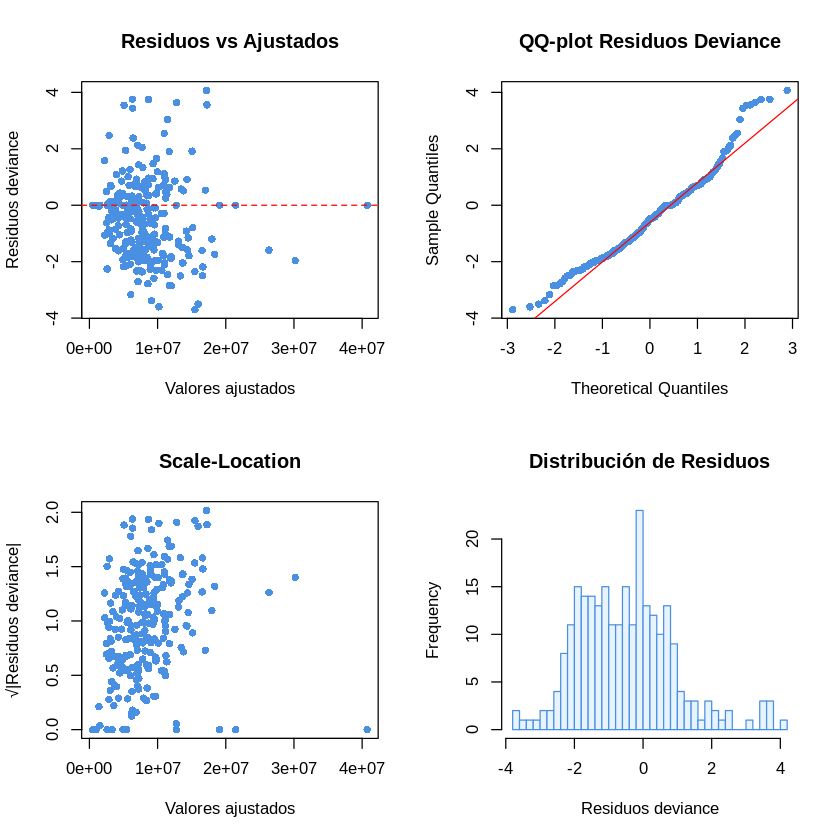

In [46]:
# 1. Extraer residuos básicos
residuos_deviance <- residuals(modelo_severidad_final, type = "deviance")
residuos_pearson <- residuals(modelo_severidad_final, type = "pearson")
valores_ajustados <- fitted(modelo_severidad_final)

# 2. Panel de diagnósticos básicos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

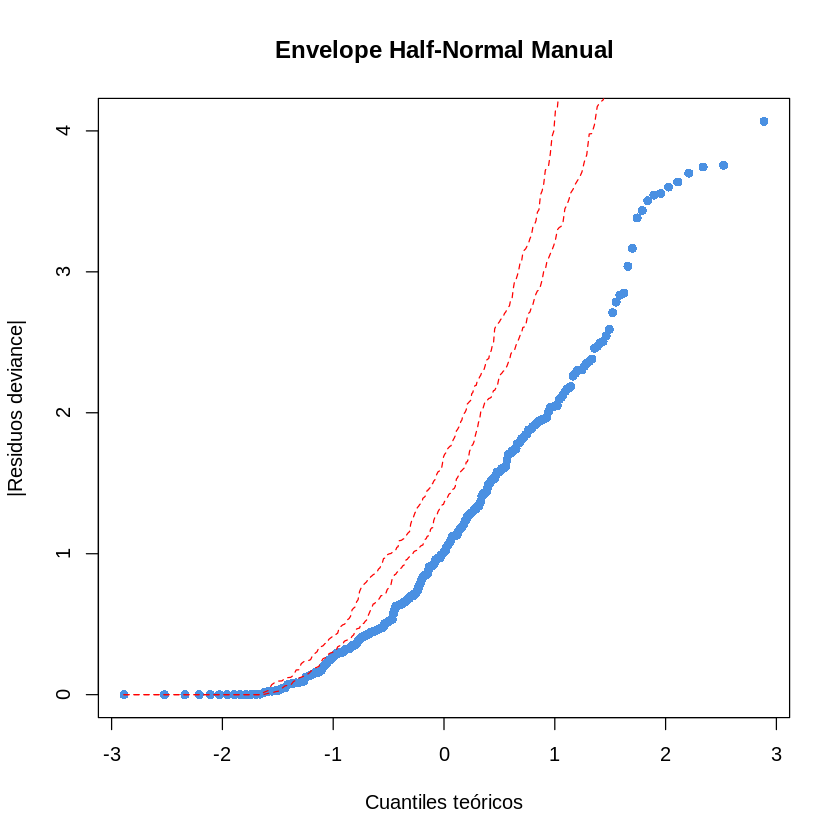

In [47]:
# Función para crear envelope manualmente
envelope_gamma_manual <- function(modelo, nsim = 99, conf = 0.95) {
  n <- length(residuals(modelo))
  
  # Extraer información del modelo
  y <- modelo$y
  mu <- fitted(modelo)
  phi <- summary(modelo)$dispersion
  
  # Matriz para almacenar residuos simulados
  res_sim <- matrix(NA, n, nsim)
  
  # Simular datos y calcular residuos
  set.seed(123)
  for(i in 1:nsim) {
    # Simular respuestas desde Gamma
    y_sim <- rgamma(n, 
                    shape = 1/phi, 
                    scale = mu * phi)
    
    # Ajustar modelo (con manejo de errores)
    tryCatch({
      modelo_sim <- glm(y_sim ~ ., 
                       data = modelo$data,
                       family = Gamma(link = "log"),
                       weights = modelo$prior.weights)
      
      res_sim[,i] <- sort(abs(residuals(modelo_sim, type = "deviance")))
    }, error = function(e) {
      res_sim[,i] <- NA
    })
  }
  
  # Calcular bandas de confianza
  alpha <- (1 - conf) / 2
  lower <- apply(res_sim, 1, quantile, probs = alpha, na.rm = TRUE)
  upper <- apply(res_sim, 1, quantile, probs = 1-alpha, na.rm = TRUE)
  
  # Crear gráfico
  res_obs <- sort(abs(residuals(modelo, type = "deviance")))
  valores_teoricos <- qnorm((1:n - 0.5) / n)
  
  plot(valores_teoricos, res_obs,
       pch = 16, col = "#4A90E2",
       xlab = "Cuantiles teóricos",
       ylab = "|Residuos deviance|",
       main = "Envelope Half-Normal Manual")
  
  lines(valores_teoricos, lower, col = "red", lty = 2)
  lines(valores_teoricos, upper, col = "red", lty = 2)
  
  # Retornar información
  invisible(list(
    observed = res_obs,
    lower = lower,
    upper = upper,
    theoretical = valores_teoricos
  ))
}

# Usar la función
envelope_manual <- envelope_gamma_manual(modelo_severidad_final)

No sirve el modelo

Start:  AIC=9143.91
suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad



Gaussian model (glm object) 


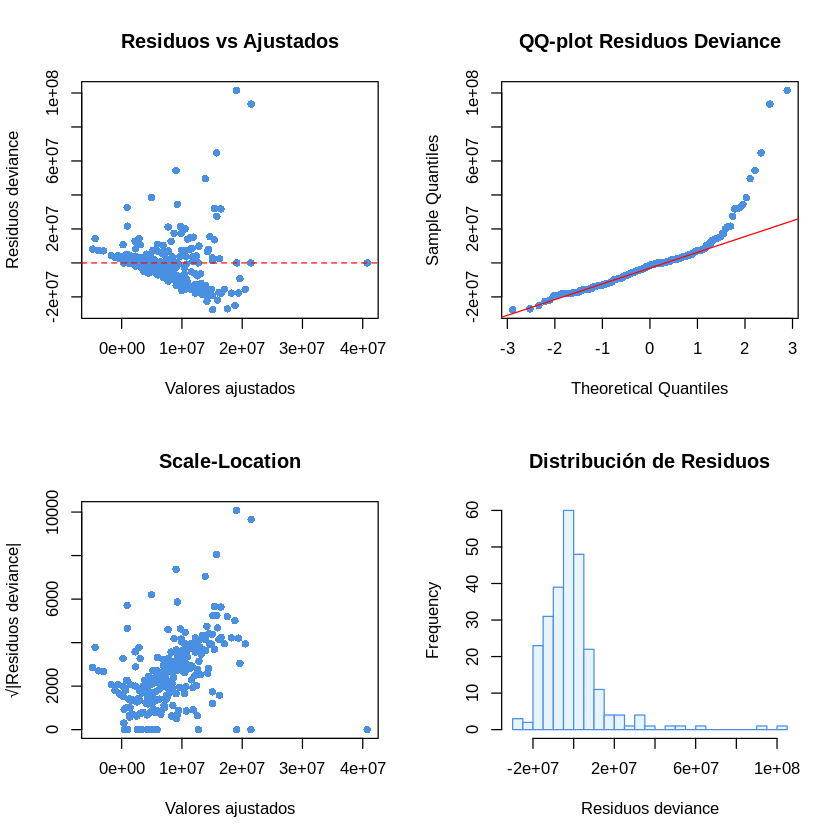

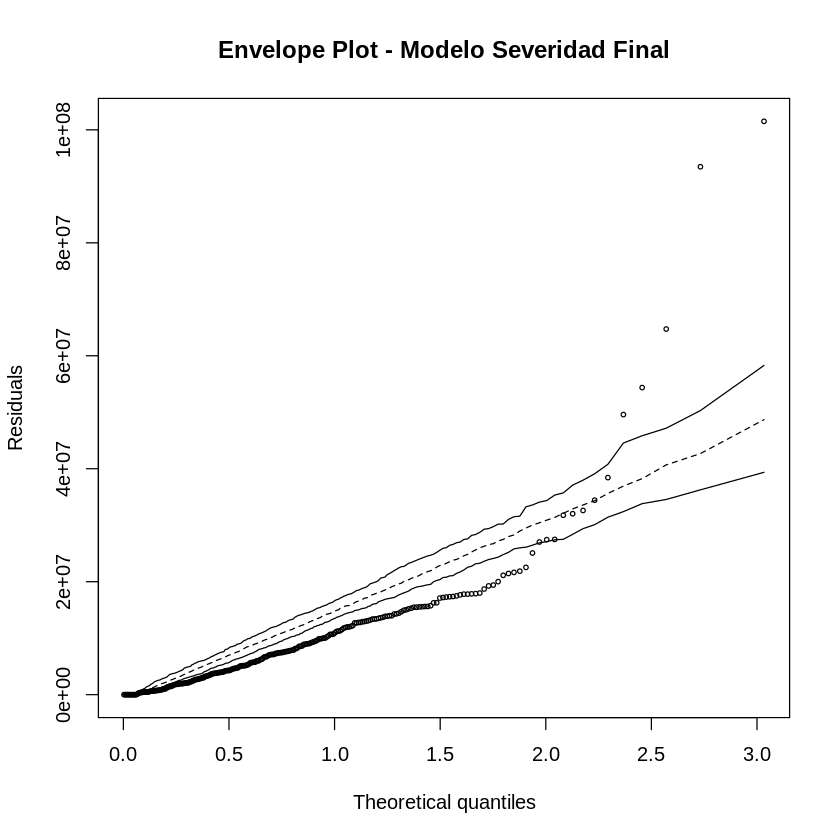

In [69]:
# Modelo completo de severidad
modelo_sev_completo <- glm(
  suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad,
  family = gaussian,
  weights = n_siniestros,
  data = data
)

# Modelo nulo de severidad
modelo_sev_nulo <- glm(
  suma_pagos ~ 1,
  family = gaussian,
  weights = n_siniestros,
  data = data
)

# Stepwise
modelo_severidad_final <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

# 1. Extraer residuos básicos
residuos_deviance <- residuals(modelo_severidad_final, type = "deviance")
residuos_pearson <- residuals(modelo_severidad_final, type = "pearson")
valores_ajustados <- fitted(modelo_severidad_final)

# 2. Panel de diagnósticos básicos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para el modelo de severidad final
envelope_severidad <- hnp(modelo_severidad_final,
                         halfnormal = TRUE,
                         plot = TRUE,
                         main = "Envelope Plot - Modelo Severidad Final")

## con quasi-Gamma

In [73]:
# Paso 1: Usar Gamma estándar para selección de variables
modelo_sev_gamma <- glm(
  suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

modelo_gamma_nulo <- glm(
  suma_pagos ~ 1,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

# Selección con step
modelo_gamma_step <- step(
  modelo_sev_gamma,
  scope = list(lower = modelo_gamma_nulo, upper = modelo_sev_gamma),
  direction = "both",
  trace = TRUE
)

# Paso 2: Usar la fórmula seleccionada para ajustar quasi-Gamma
formula_seleccionada <- formula(modelo_gamma_step)

modelo_severidad_quasi_final <- glm(
  formula_seleccionada,
  family = quasi(link = "log", variance = "mu^2"),
  weights = n_siniestros,
  data = data
)

summary(modelo_severidad_quasi_final)

Start:  AIC=23086.3
suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad


Step:  AIC=23086.3
suma_pagos ~ valor + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    SERVICIO + Sexo_Aseg + Grupo_Edad

                  Df Deviance   AIC
- Modelo          17   572.88 23075
- Carroceria       7   538.29 23080
- Color           18   595.07 23082
- CLASE_FASECOLDA  4   530.50 23083
- Grupo_Edad       2   525.18 23085
- Sexo_Aseg        1   523.62 23086
<none>                 519.03 23086
- SERVICIO         2   529.40 23087
- valor            1   537.73 23092

Step:  AIC=23128.23
suma_pagos ~ valor + Color + Carroceria + CLASE_FASECOLDA + SERVICIO + 
    Sexo_Aseg + Grupo_Edad




Call:
glm(formula = formula_seleccionada, family = quasi(link = "log", 
    variance = "mu^2"), data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7000  -1.5510  -0.4901   0.3418   4.0680  

Coefficients: (2 not defined because of singularities)
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                             1.629e+01  2.266e-01  71.897  < 2e-16
valor                                   2.717e-10  1.197e-10   2.270  0.02419
ColorAMARILLO                          -2.509e+00  1.077e+00  -2.329  0.02076
ColorAZUL                              -4.619e-01  2.457e-01  -1.880  0.06140
ColorBEIGE                              1.607e-01  6.760e-01   0.238  0.81228
ColorBLANCO                            -7.462e-02  2.422e-01  -0.308  0.75829
ColorCAFE                               6.517e-01  8.197e-01   0.795  0.42742
ColorCHAMPAÑA                          -2.245e-01  5.317e-01  -0.422  0.

In [82]:
envelope_quasi_half <- hnp(modelo_severidad_quasi_final, 
                           sim = 99,
                           conf = 0.95,
                           resid.type = "pearson",
                           halfnormal = TRUE)

ERROR: Error in obj[, 1]: incorrect number of dimensions


# Frecuencia